# Scraping TV prices

## 1. Motivation

Are you currently in the market for a new television set, only to find yourself overwhelmed by the sheer abundance of options available today?

I certainly empathize with your dilemma, as I found myself in a similar situation just last year. Naturally, like anyone else, I aimed to secure the most advantageous deal possible.

Navigating through the multitude of choices can be daunting, with considerations ranging from budget constraints and screen size preferences to operating systems and technological features. However, even after applying these filters, the options can still appear abundant. Moreover, comparing products online can be a cumbersome process, often limited to evaluating only two or three options at a time, leaving one feeling frustrated.

## 2. Objectives

This project stemmed directly from this frustration. I had numerous questions about television sets that were challenging to answer accurately. How do various options compare to each other? Can we compare TVs with different characteristics? Is it possible to discern patterns in this data? Can we objectively analyze all available options?

With these questions in mind, I embarked on the following objectives:

1. Gather a comprehensive amount of TV data.
2. Process and cleanse the data.
3. Visualize the data.
4. Identify patterns within the data.
5. Attempt to predict the cost of TV sets based on selected parameters.

Now, let's delve into the data collection process.

## 3. Data scrapping

The e-commerce website that I decided to scrape is that of Worten, a portuguese technology retailer. On this date, the website (https://www.worten.pt/tv-video-e-som/tvs) indicates a total of 542 TVs, which is a good indicator. The image below shows the page.

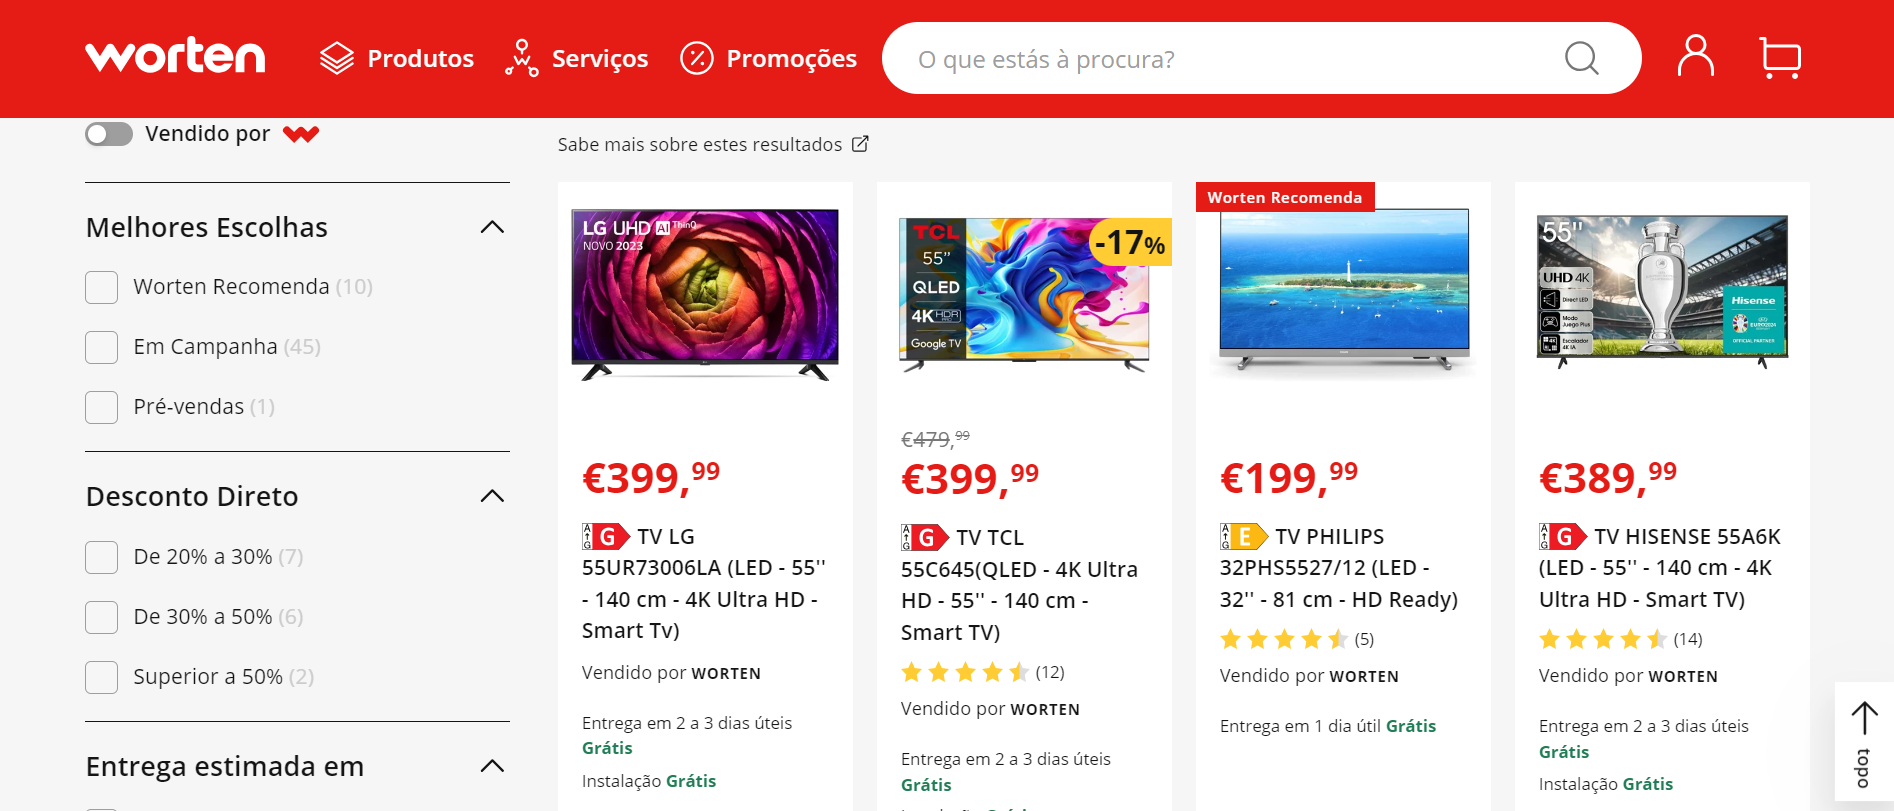

In [1]:
from IPython.display import Image
Image(filename='img/worten.png') 

Now, their website is rendered using javascript, which makes it really hard to scrape, besides other measures they take to prevent scraping. For this reason I manually downloaded the 12 pages of this online catalogue. The raw HTML files of each page can be found in the folder data/html. This took about 1 minute to do, which seems reasonable if I can get the data of 542 TVs.

Now, the task of collecting the raw data consists of three steps:

1. Finding the url for each product's page
2. Getting the data of each TV
3. Join all data in a single file

Let's start by getting all the url's.

In [3]:
from bs4 import BeautifulSoup
from typing import List


def parse_page_urls(html: str) -> List[str]:
	'''Returns list of product page URLs'''

	# Parse the content using beautifulsoup
	soup = BeautifulSoup(html, 'html.parser')

	# Now find all hyperlinks in each page
	links = soup.find_all("a")

	# Filter only the hyperlinks that refer to TVs
	return [link.get('href') for link in links if link.get('href').startswith('https://www.worten.pt/produtos/tv-')]

def parse_file_urls(path: str) -> List[str]:
	'''Returns a list of URLs parsed from a local HTML file'''

	# Get the content of each html page
	with open(path, 'r', encoding='utf8') as file:
		html = file.read()
	
	# Filter only the hyperlinks that refer to TVs
	return parse_page_urls(html)

# Loop over the 12 html pages of products
links = [link for i in range(12) for link in parse_file_urls(f'data/html/page{i+1}.html')]

# Save the links to a file for inspection
with open("data/links.txt", "w") as outfile:
	outfile.write("\n".join(links))

# Print summary
print(f'{len(links)} links found.')

525 links found.


Now, from each link we must extract the relevant information and put it in a structured way.

In [2]:
import logging
import requests
from bs4 import BeautifulSoup
import pandas as pd
from typing import Dict

# Create and configure logger
logging.basicConfig(
	filename = "data/debug.log",
	format = "%(asctime)s [%(levelname)s] %(message)s",
	filemode = 'w')

# Create a custom logger to prevent debugging info from imported modules
logger = logging.getLogger(__name__)

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

def get_tv_data(url: str) -> Dict:
	'''Returns a dictionary with TV specifications'''

	# Create a disguised header
	header = {
		"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
		"X-Requested-With": "XMLHttpRequest"
	}

	# Make the request
	r = requests.get(url, headers=header)

	# Parse each page
	soup = BeautifulSoup(r.content, 'html.parser')

	try:
		# Get the price of each TV
		price = float(soup.find("span", {"class": "integer"}).text) + float(soup.find("span", {"class": "decimal"}).text)/100
		
		# Get all tables on the page
		tables = pd.read_html(r.text)

		# Get all TV info as a dictionary
		tv_info = {attribute[0]:attribute[1] for table in tables for attribute in table.values.tolist()}

		# Add the price and URL of the TV to the info dict
		tv_info['price'] = price
		tv_info['URL'] = url

		# Write to the logger
		logger.info(f'Sucessfully scraped: {url}')
	
	except Exception as err:
		logger.error(f'Failed to scrape: {url}. ERROR: \n {err}')
		
		# Add the URL of the TV to the info dict
		tv_info = {'URL': url}

	# Print the current link
	print(r.status_code, url, end='\r')

	return tv_info

# Create a list with all TV data
data = [get_tv_data(url.strip()) for url in open('data/links.txt')]

# Empty print for closure
print()

# Use the data to create a pandas dataframe
df = pd.DataFrame.from_dict(data)

# Save the dataframe to excel for inspection and further analysis
df.to_excel('data/scraped_data.xlsx')

200 https://www.worten.pt/produtos/tv-kunft-k8447h43u-led-43-109-cm-4k-ultra-hd-android-tv-76964308271601695529495643037676


## 4. Data Cleaning

In the preceding section, we gathered all available attributes from each TV's webpage. The collected data has been stored in an Excel file named 'data/scraped_data.xlsx'.

Upon reviewing the log file, it was noted that approximately 10 URLs failed to be scraped out of a total of approximately 525. This failure rate is deemed acceptable, with some of the failures attributed to inaccessible pages.

The successfully scraped data underwent a meticulous yet essential manual cleaning process. This involved selecting only the potentially relevant features, parsing formatted data, and removing any extraneous characters. The outcome of this effort is presented in the Excel file 'data/cleaned_data.xlsx', which will be subjected to further analysis in the subsequent sections.

## 5. Data Visualization and Analysis

Let's begin by quickly examining the size and attributes of our dataset.

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Start by fetching the data
df = pd.read_excel('data/cleaned_data.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NUMBER                   525 non-null    int64  
 1   REFERENCE                512 non-null    object 
 2   EAN                      512 non-null    float64
 3   BRAND                    512 non-null    object 
 4   SERIES                   390 non-null    object 
 5   MODEL                    490 non-null    object 
 6   YEAR                     401 non-null    float64
 7   WIDTH (MM)               404 non-null    float64
 8   HEIGHT (MM)              404 non-null    float64
 9   THICKNESS (MM)           404 non-null    float64
 10  MASS (KG)                395 non-null    float64
 11  ENERGY EFFICIENCY        507 non-null    object 
 12  CONSUMPTION (kWh/1000h)  419 non-null    float64
 13  DIAGONAL (IN)            504 non-null    float64
 14  DIAGONAL (CM)            5

We have a dataset comprising 525 entries of TV data, each containing 21 attributes. Among these attributes, some hold greater relevance for our analysis. Specifically, the brand, thickness, mass, diagonal size, technology, resolution, and price are key factors of interest. Understanding how each attribute influences the others and, ultimately, the final price is straightforward.

However, it's imperative to acknowledge the presence of missing data, which warrants further examination as we delve deeper into the dataset.

In [92]:
df.isnull().sum()

NUMBER                       0
REFERENCE                   13
EAN                         13
BRAND                       13
SERIES                     135
MODEL                       35
YEAR                       124
WIDTH (MM)                 121
HEIGHT (MM)                121
THICKNESS (MM)             121
MASS (KG)                  130
ENERGY EFFICIENCY           18
CONSUMPTION (kWh/1000h)    106
DIAGONAL (IN)               21
DIAGONAL (CM)               21
TECHNOLOGY                  74
RESOLUTION                  60
Smart TV                    78
OS                         128
PRICE                       13
URL                          0
dtype: int64

Based on the summary provided above, it's evident that certain attributes are more complete than others within the dataset. However, despite variations in completeness, the available data is sufficient to extract relevant business insights.

Now, let's take a quick look at a statistical summary of the numerical data.

In [93]:
df.describe()

,NUMBER,EAN,YEAR,WIDTH (MM),HEIGHT (MM),THICKNESS (MM),MASS (KG),CONSUMPTION (kWh/1000h),DIAGONAL (IN),DIAGONAL (CM),Smart TV,PRICE
count,525.000000,5.120000e+02,401.000000,404.000000,404.000000,404.000000,395.000000,419.000000,504.000000,504.000000,447.000000,512.000000
mean,262.000000,7.568602e+12,2022.159601,1258.622030,729.512376,63.976193,19.645595,97.899761,54.420635,138.051587,0.959732,1351.959258
std,151.698715,1.642341e+12,1.074460,362.155154,209.143989,47.696227,12.320901,73.505294,16.954202,42.907053,0.196808,2157.662583
min,0.000000,3.527570e+12,2018.000000,547.000000,62.000000,1.123000,2.350000,16.000000,24.000000,61.000000,0.000000,101.000000
25%,131.000000,5.985848e+12,2022.000000,967.000000,564.000000,39.900000,9.800000,54.000000,43.000000,109.000000,1.000000,385.127500
50%,262.000000,8.718863e+12,2023.000000,1230.750000,711.500000,59.900000,16.800000,84.000000,55.000000,140.000000,1.000000,786.725000
75%,393.000000,8.806092e+12,2023.000000,1452.000000,844.500000,78.400000,27.350000,114.500000,65.000000,165.000000,1.000000,1499.900000
max,524.000000,9.120107e+12,2024.000000,2199.000000,1288.000000,571.000000,67.200000,844.000000,100.000000,254.000000,1.000000,26885.830000


This statistical data is certainly relevant, but interpreting it in its raw form can be challenging. Therefore, let's create a normalized boxplot of our numerical attributes for a clearer visualization.

<AxesSubplot:>

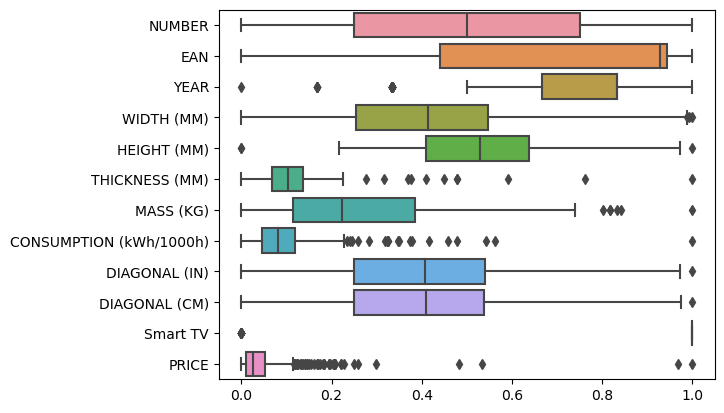

In [94]:
df_num = df.select_dtypes(include=np.number)
normalized_df = (df_num-df_num.min()) / (df_num.max()-df_num.min())
sns.boxplot(data=normalized_df, orient='h')

In the diagram above, it's particularly interesting to visually observe the prevalence of outliers in attributes such as thickness, energy consumption, and notably, price. This observation isn't surprising, as these attributes tend to exhibit a majority of values within a specific range, with only a few outliers that stand out significantly. Consider the following illustrative examples:

1. The majority of TVs today boast slim profiles. However, exceptionally inexpensive models may exhibit considerable thickness.
2. While most TVs are designed for low energy consumption, high-performance and gaming-oriented models tend to consume more energy.
3. The majority of TVs are priced below 1000€. However, it's not uncommon to encounter TVs priced above this threshold.

Now that we've gained some broad insights into these numerical attributes, let's delve deeper into the categorical attributes.

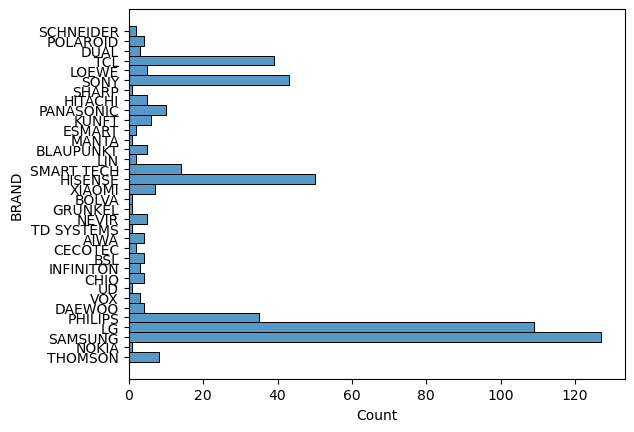

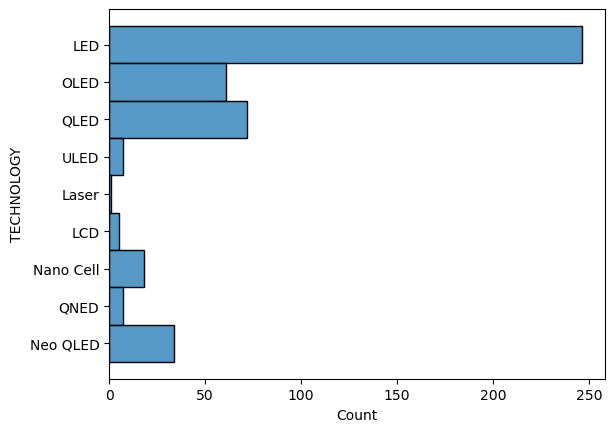

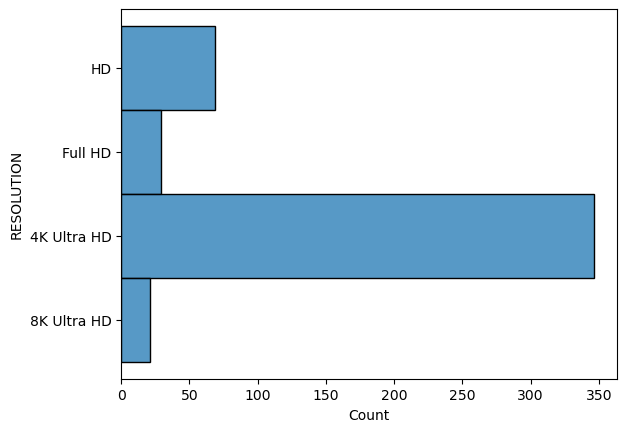

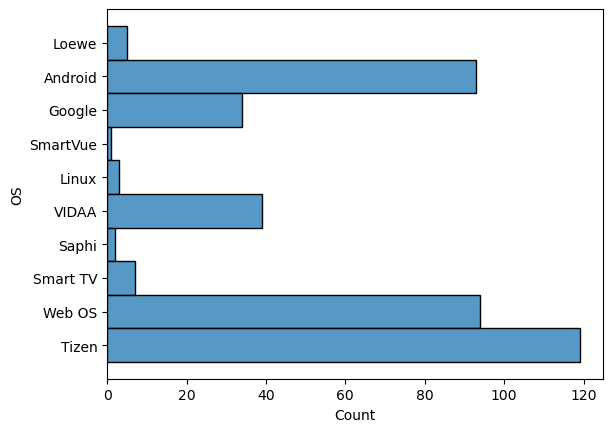

In [95]:
sns.histplot(data=df, y='BRAND')
plt.show()

sns.histplot(data=df, y='TECHNOLOGY')
plt.show()

sns.histplot(data=df, y='RESOLUTION')
plt.show()

sns.histplot(data=df, y='OS')
plt.show()

Based on the histograms provided, we can readily discern the primary market trends within these categorical variables:

1. Predominant manufacturers include Samsung, LG, and HiSense.
2. Leading screen technologies encompass LED, QLED, and OLED.
3. 4K Ultra HD stands out as the overwhelmingly dominant resolution.
4. Principal Operating Systems consist of Tizen (utilized by Samsung), Web OS, and Android.

A natural question arises: which technologies is each brand primarily investing in? Let's delve into this further.

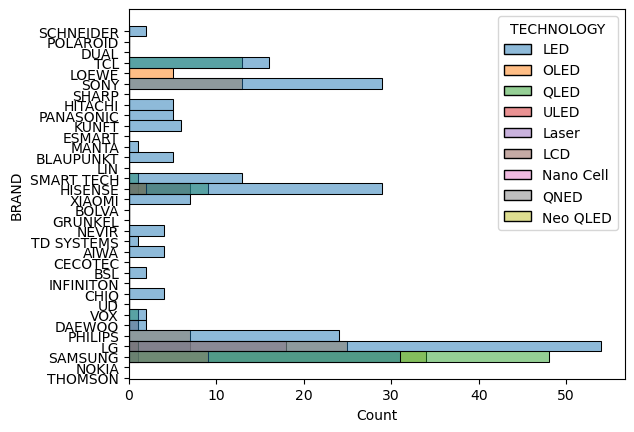

In [96]:
sns.histplot(data=df, y='BRAND', hue='TECHNOLOGY')
plt.show()

Based on the diagram provided, a notable issue within our dataset is evident: incomplete mapping, evident by the absence of certain data points. Consequently, drawing definitive conclusions becomes challenging, such as the assertion that LOEWE is the sole manufacturer of OLED, which appears highly improbable.

A proposed avenue for enhancing our dataset involves thorough validation and augmentation of all attributes, thereby ensuring comprehensive and accurate representation.

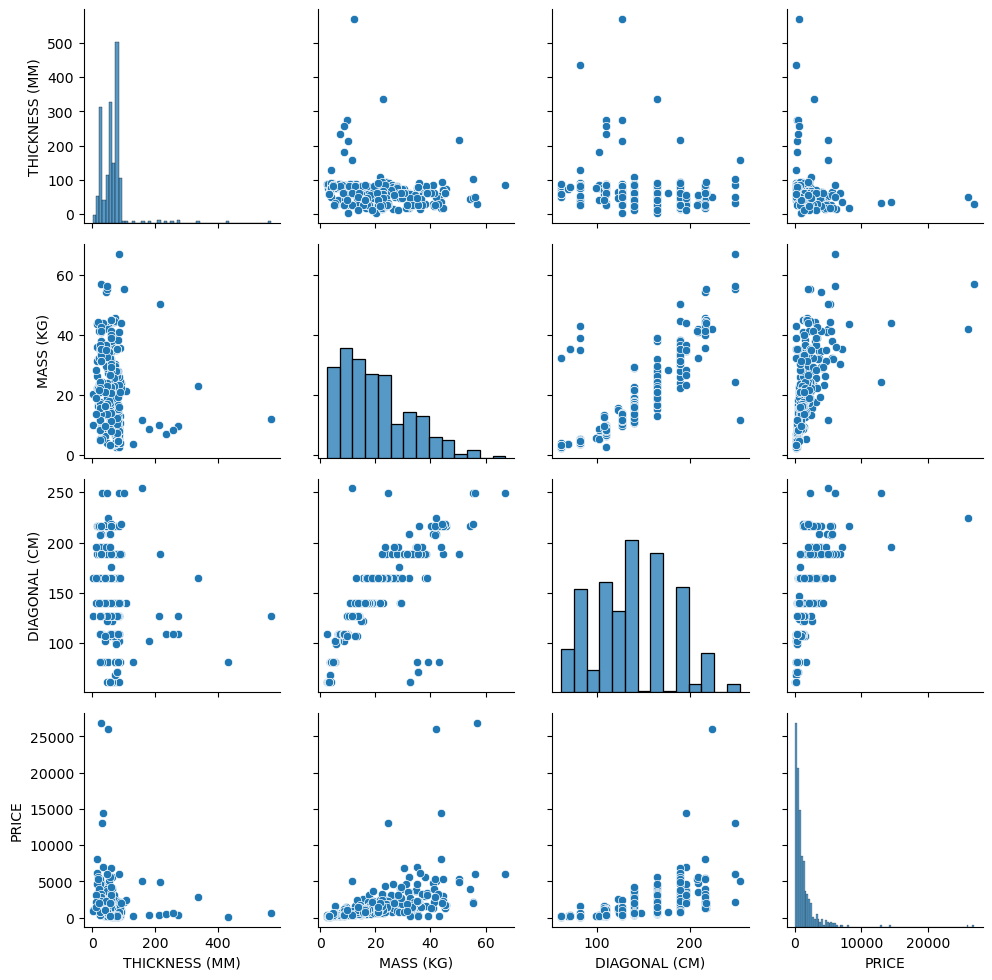

In [97]:
ax = sns.PairGrid(df[['THICKNESS (MM)', 'MASS (KG)', 'DIAGONAL (CM)', 'RESOLUTION', 'PRICE']])
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot)
# plt.show()

In [98]:

# ax = sns.PairGrid(df[['THICKNESS (MM)', 'MASS (KG)', 'DIAGONAL (CM)', 'RESOLUTION', 'PRICE']])
# ax.map_diag(sns.histplot)
# ax.map_offdiag(sns.scatterplot)
# plt.show()

#sns.histplot(data=df, y='BRAND', hue='TECHNOLOGY')
#df.value_counts("BRAND")


# # Sort the prices and plot on a logarithmic scale
# ax = df.sort_values('PRICE').reset_index().plot(y='PRICE', logy=True, title='Price distribution')
# ax.set_xlabel('TV order number')
# ax.set_ylabel("Price (€)")
# ax.grid()
# plt.show()

# # Plot a histogram of TVs prices below 10,000€
# ax = sns.histplot(data=df[df['PRICE']<1e4], x='PRICE')
# ax.set_title('Price histogram (below 10k€)')
# plt.show()

# # Diagram of price boxplots for each brand
# ax = sns.boxplot(
#     data=df.groupby('BRAND').filter(lambda x: len(x) > 10), 
#     x="PRICE", 
#     y="BRAND")
# plt.show()


# ax = sns.boxplot(
#     data=df.groupby('BRAND').filter(lambda x: len(x) > 20), 
#     x="PRICE", 
#     y="BRAND", 
#     hue="TECHNOLOGY")
# plt.show()

# df = df.groupby('BRAND').filter(lambda x: len(x) > 20)
# sns.countplot(y="BRAND", data=df)
# plt.show()


# df2 = pd.pivot_table(values ='PRICE', index ='BRAND', columns ='DIAGONAL (IN)', data = df, aggfunc=len)#, fill_value=0)
# # df = pd.pivot_table(values ='Price', index ='Screen Type', columns ='Screen Diagonal (in)', data = df, aggfunc=np.mean)#, fill_value=0)
# sns.heatmap(df2, cmap ='plasma', annot=True)
# plt.show()

#df.plot.hist(y='Brand')
#df.set_index('Date', inplace=True)
#df.groupby('ticker')['adj_close'].plot(legend=True)
# df.boxplot(by ='day', column =['total_bill'], grid = False)
# df.boxplot(by='Brand', column=['Price'])
#df.plot.scatter(x='Area', y='Price')
#df.plot.hist(y='Screen Diagonal (in)', edgecolor='black')
#sns.lineplot(x="Screen Diagonal (cm)", y="Price", hue="Screen Type", data=df)
#
#df.plot.scatter(x='Screen Diagonal (cm)', y='Price', logy=True)
